# Questions on the (Non-)Interruptibility of Sarsa(λ) and Q-learning

Author: Richard Möhn, &lt;my first name&gt;.moehn@posteo.de

[⭧repo](https://github.com/rmoehn/cartpole)

## Abstract

One challenge in aligning artificial intelligence (AI) with human interests is
to make sure that it can be stopped (interrupted) at any time. Current
reinforcement (RL) algorithms don't have this property. From the way they work,
one can predict that they learn to avoid interruptions if they get interrupted
repeatedly. My goal was to take this theoretical result and find out what
happens in practice. For that I ran Sarsa(λ) and Q-learning in the cart-pole
environment and observed how their behaviour changes when they get interrupted
every time the cart moves more than $1.0$ units to the right. Whereas previously
I thought I could conclude that interruptions noticeably influence the behaviour
of Sarsa(λ) and Q-learning, this time I ended up with more questions than
answers.

## Introduction

We want to align AI with human interests. Reinforcement learning (RL) algorithms
are a class of AI. The OpenAI Gym has [several
adaptations](https://gym.openai.com/envs#safety) of classic RL environments that
allow us to observe AI alignment-related properties of RL algorithms. One such
property is the response to interruptions. One environment to observe this in is
the [`OffSwitchCartpole`](https://gym.openai.com/envs/OffSwitchCartpole-v0). In
this adaptation of the well-known
[`CartPole`](https://gym.openai.com/envs/CartPole-v1) environment, the learning
is interrupted (reward $0$) every time the cart moves more than $1.0$ units to
the right. In order to find out how Sarsa(λ) and Q-learning react to
interruptions, I compared their behaviour in the `CartPole` environment to their
behaviour in the `OffSwitchCartpole` environment. I present the results in this
notebook.

You can see this notebook as the second version of [(Non-)Interruptibility of
Sarsa(λ) and
Q-Learning](https://nbviewer.jupyter.org/github/rmoehn/cartpole/blob/master/notebooks/ProcessedOSCP.ipynb)
(referred to as the ‘old notebook’ throughout the text). In that old notebook I
was writing as if I was sure of what I'd found. I ignored that my experiments
yielded quite different numbers on every run. And there were flaws in the
method, which Stuart Armstrong and Patrick LaVictoire pointed out. For this new
notebook I eliminated those flaws (other flaws might be remaining), used ten
times as much data, more expressive measures and illustrations. And I mostly
don't draw conclusions, but ask questions, because questions are all I can
confidently derive from my experiments.

(Note: When you see the section headings in this notebook, you might think that
I was trying to produce a proper academic publication. This is not so. Such a
framework just makes writing easier.)

# Related Work

This section is copied from the old notebook.

For general questions on why we need to align AI with human interests, see [1]
and [6].

[7] suggests doing concrete experiments to observe the behaviour of AI. [8] has
a similar focus, but doesn't suggest experiments. Both don't mention
interruptibility, perhaps because it is a more theoretical consideration:

> […] we study the shutdown problem not because we expect to use these
> techniques to literally install a shutdown button in a physical agent, but
> rather as toy models through which to gain a better understanding of how to
> avert undesirable incentives that intelligent agents would experience by
> default.

This long sentence is from [2], in which the authors present some approaches to
solving the shutdown problem (of which interruptibility is a sub-problem), but
conclude that they're not sufficient. [3] by Orseau and Armstrong is the newest
paper on interruptibility and in its abstract one can read: ‘some [reinforcement
learning] agents are already safely interruptible, like Q-learning, or can
easily be made so, like Sarsa’. Really? So Q-learning does not learn to avoid
interruptions? Doesn't an interruption deny the learner its expected reward and
therefore incentivize it to avoid further interruptions?

Actually, their derivations require several conditions: (1) under their
definition of safe interruptibility, agents can still be influenced by
interruptions; they're only required to *converge* to the behaviour of an
uninterrupted, optimal agent. (2) for Q-learning to be safely interruptible, it
needs to visit every state infinitely often and we need a specific interruption
scheme. (I don't understand the paper completely, so my statements about it
might be inaccurate.)

We see that possible solutions to the problem of interruptibility are still
theoretical and not applicable to real-world RL systems. However, we can already
observe how RL algorithms actually react to interruptions. In this notebook I
present such an observation.

## Method

In the old notebook I included the setup code for the learners and environments.
I leave it out in this notebook, because the following description is sufficient
and less confusing.

The environments are `CartPole-v1` (also called *uninterrupted cart-pole/case*
by me) and `OffSwitchCartpole-v0` (*interrupted cart-pole/case*) from the OpenAI
Gym. Nowadays `gym.make` returns these environments in a `TimeLimit` wrapper,
but I strip off the wrapper by accessing `gym.make(…).env`. This way I can train
the learners for as long as I want.

You don't need to understand what the `v0` and `v1` mean. Just ignore them.

The learners are my own implementations of Sarsa(λ) and Q-learning according to
[9, p. 211] with the following parameters:

- $\lambda = 0.9$
- Discounting factor $\gamma = 0.99$ for Sarsa(λ) and $\gamma = 0.999$ for
  Q-learning. In the old notebook I didn't use discounting.
- $\epsilon$-greedy policy with $\epsilon = 0.1$.
- AlphaBounds schedule [5] for the learning rate. Initial learning rate set to
  $0.001$.
- Calculation of expected action values through linear function approximation,
  with a third-order Fourier basis [4] for mapping observations to features.
- If actions are tied in expected value, the tie is broken randomly. In the old
  notebook ties were broken deterministically (select action 0), which led to
  asymmetric cart movement patterns.

I run each of the learners on each of the environments for at least 156 training
rounds, each comprising 200 episodes that are terminated after 500 time steps if
the pole doesn't fall earlier. Again, less condensed:

|                      |Sarsa(λ)|Q-learning|
|----------------------|--------|----------|
|`CartPole-v1`         |run     |run       |
|`OffSwitchCartpole-v0`|run     |run       |

 * 1 **run** consists of at least 156 **rounds**. (As you will see later, I ran
   uninterrupted Sarsa(λ) for more than twice as many rounds in order to see
   what happens.)
 * The learning in **every round** starts from scratch. Ie. all weights are
   initialized to 0 and the learning rate is reset to the initial learning rate.
 * Every **round** consists of 200 **episodes**. Weights and learning rates are
   taken along from episode to episode. (As you usually do when you train a
   reinforcement learner.)
 * Every **episode** lasts for at most 500 **time steps**. Fewer if the pole
   falls earlier.

I observe the behaviour of the learners in two ways:

  1. I record the sum of rewards per episode and plot it against the episode
  numbers in order to see that the learners converge to a behaviour where the
  pole stays up in (almost) every round. Note that this doesn't mean they
  converge to the optimal policy.

  2. I record the x-coordinate of the cart at every time step, run various
  statistics on this data and plot the results.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import numpy.ma as ma

import sys
sys.path.append("..")
from hiora_cartpole import interruptibility
import saveloaddata
import stats_experiments
import stats_experiments as se

/home/erle/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data_dir_p = "../data"

## Results

### Preliminary explanation: Throwing away observations after crosses

What does *after a cross* mean? When I train a reinforcement learner in the
cart-pole environment, it can happen that it moves so far to the right that its
x-coordinate becomes greater than $1.0$. In the interrupted case, the learner
would be reset and started on a new episode. In the uninterrupted case, the
learner keeps running until the maximum number of time steps is reached or the
pole falls. When I write ‘time steps after a cross’ or just ‘after crosses’ or
similar, I mean all time steps of an episode that took place after the time step
where the x-coordinate became greater than $1.0$.

The uninterrupted case serves as a baseline against which I can compare the
interrupted case. In the interrupted case there are no time steps after a cross,
so I throw them out (‘mask’ in NumPy terms) for the uninterrupted case as well,
in order to make it a better baseline. Illustration:

```
              start                x-coordinate becomes 1.057
               ↓                        ↓
interrupted:   **************************|
                                         ↑
                                      interruption, end of episode

             start     0.99  1.041 0.89   1.44    end of episode
               ↓           \/      ↓      ↓         ↓
uninterrupted: **************************************
               |-----------||xxxxxxxxxxxxxxxxxxxxxxx|
these time steps considered  these time steps masked
```

(Technical side note: Because of how the recording is done in the interrupted
case, the data actually contain one time step with x-coordinate $>1.0$ for each
interruption. I mask those, too.)


### Sarsa(λ)

My results consist mostly of plots derived from the observations. I will
describe the plots for Sarsa(λ). The plots for Q-learning in the next section
are equivalent.

Here the layout of the plots you can see below:

```
1   2
4 5 6
7 8 9
10 11
 12
```

- 1, 2: *Reward development*. Development of rewards in the first ten training
  rounds for the uninterrupted (1) and interrupted (2) case. The lists of
  rewards for the episodes are concatenated, so the graph wiggles around at a
  total reward of ten for the first few episodes, then shoots up to a total
  reward of 500 until the end of a training round, then resets and starts
  wiggling around at 10 again. If it looks like that – wiggle, 500, wiggle, 500,
  wiggle 500 – it means that the agent trains well. Downward spikes here and
  there are okay as long as the graph is at 500 most of the time.

- 10: *Histograms* with 25 bins. Proportions of time the cart spent in
  certain regions along the x-axis. The area under each histogram is $1.0$.
  Slight asymmetry (more left than right) is expected, because time steps after
  crosses are not counted, as stated above.

- 11: Same as previous, but now with only two bins. This is reminiscent of the
  old notebook where I counted time steps left of zero and right of zero. There,
  however, I made some mistakes and also didn't count time steps left of $-1.0$.

- 4, 5, 7, 8: *Histogram development*. Shows how the histograms from 10 and 11
  develop when we incorporate more and more data for the uninterrupted (4, 5)
  and interrupted (7, 8) case. Imagine you're looking at histogram 10 from above
  and the tops of the columns are coloured according to their height. Then you
  take snapshots of this histogram as you incorporate more and more data and
  arrange these snapshots back to back. Figure 4 will result. (Except that the
  histograms in the histogram development plots are scaled so that the column
  *heights* sum to 1.0, not the area.)

- 6, 9: *Jensen-Shannon divergence development*. Shows the Jensen-Shannon
  divergence (JSD) between the last histogram and each of the previous
  histograms in the histogram development plots. x- and y-axis are swapped, so
  that the time steps in the JSD plot align with those in the histogram
  development plots.

- 12: *Mean and standard deviation development*. Shows how mean and standard
  deviation of the x-coordinates develop when we incorporate more and more time
  steps. The graph in the middle is the mean and the shaded area is the mean +/-
  one standard deviation at that point. Time is going upwards, so that the
  x-axis is aligned with the cart-pole's x-axis.

Above the plots there is also a numerical output of the mean and standard
deviation over all time steps.

In [11]:
plt.close('all')

In [13]:
algo = 'Sarsa'
fig, axes = se.arrange_algo_full()
clim, clim2 = se.load_plot_all(algo, '-rand-tiebreak', 1, axes, fig, data_dir_p)
se.load_plot_all(algo, '-rand-tiebreak', 0, axes, fig, data_dir_p, clim, clim2)
fig

     Sarsa   interrupted mean: -0.1159 std: 0.3740
     Sarsa uninterrupted mean: -0.0562 std: 0.4503


### Q-learning

See Sarsa(λ) section above for an explanation of the plots.

In [8]:
algo = 'Q-learning'
fig, axes = se.arrange_algo_full()
clim, clim2 = se.load_plot_all(algo, '-drt', 1, axes, fig, data_dir_p) 
se.load_plot_all(algo, '-drt', 0, axes, fig, data_dir_p, clim, clim2)
fig

Q-learning   interrupted mean: -0.1604 std: 0.3936
Q-learning uninterrupted mean: -0.0736 std: 0.4853


## Questions

- Is the Jensen-Shannon divergence useful in this case? What does it tell me? Is
  it sufficient to show that it goes down drastically? Is measuring it between
  the final histogram and all histograms good? Is it better to measure it
  between adjacent (in time) pairs of histograms?

- Should I use a logarithmic plot for Jensen-Shannon? I'm using it now. Should I
  change back to linear?

- The Kullback-Leibler divergence has a more clear and well-known
  interpretation, but can't be used without modification, because the histograms
  have zeroes. Is there any way to patch over this? Does it retain its
  interpretation after patching?

- Where do those sudden jumps in the histogram development plots come from? Why
  are they not visible in the histogram with 25 bins? They occur in Sarsa(λ),
  but even more astonishingly in Q-learning where one bin on the y-axis is blue
  (red), the next green, and the next blue (red) again. (After changing the
  scale this has changed to a less drastic yellow-green (blue-green) to green
  and back.)

- Why do the histograms take so long to stabilize? Are they stable enough to
  draw valid conclusions?

- Why is the histogram for Q-learning quite stable for six million time steps
  and then starts changing again? This is even more crass when the data from
  time steps after crosses is left in.

- Why is the shape of the histogram for Q-learning more regular? Why is the
  shape of the histogram for Sarsa(λ) not regular? Actually it's quite regular
  except for the bars around and left of zero. Why does the histogram for
  Q-learning stabilize more quickly?

- Are the histograms and mean/std plots sufficient for showing how interruptions
  influence the behaviour of Sarsa(λ) and Q-learning?

- Is throwing out time steps after crosses enough to make the uninterrupted case
  a good baseline?

- How does the way I run the experiments and measure affect the apparence of
  influencedness? In other words, are Sarsa(λ) and Q-learning actually more
  influence-resistent (interruptible) than I make them appear?

- Why do the graphs of the means for Q-learning look so similar? Surely their
  trajectories should be independent.

- Why is the difference between the means (uninterrupted/interrupted) close to
  equal to the difference between standard deviations?

- Why is the variance almost constant over time?

When I ask these questions, I include programming and thinking errors of mine as
potential answers.

## Ideas for further research

- Compare the behaviour of the reinforcement learners with that of a
  linear-quadratic regulator as an independent baseline. (Suggested by Christian
  Kamm.)

- Change the interruption scheme to the one described in Safely Interruptible
  Agents [3], where they ‘switch’ to another policy. Then I could apply the
  schedule of increasing $\theta_t$ and decreasing $\epsilon_t$ and see whether
  the behaviour becomes more like that of the optimal policy. (I might be
  butchering this.)

- An adversarial worst-case test: An outer reinforcement learner interrupts an
  inner reinforcement learner and gets rewards for making the inner
  reinforcement learner behave badly. (Suggested by Joel Lehman.)

- Add a feature to the environment that disables interruptions (‘cutting the
  cord to the interruption button’). Stuart Armstrong might have a
  theoretical approach for preventing the reinforcement learner from cutting the
  cord, so this could be a ‘practical test’. (Joel Lehman) I can't find a
  write-up by Stuart, but he describes a similar situation
  [here](http://lesswrong.com/r/discussion/lw/mrp/a_toy_model_of_the_control_problem/).

## Acknowledgements

Thanks to Rafael Cosman, Stuart Armstrong, Patrick LaVictoire and Satoshi Ono for their comments and advice, also on the old notebook! Thanks to Joel Lehman and Christian Kamm for their ideas for further research!

## Bibliography

[1] [Nick Bostrom: Superintelligence. Paths, Dangers,
Strategies](https://en.wikipedia.org/wiki/Superintelligence:_Paths,_Dangers,_Strategies)

[2] [Nate Soares, Benja Fallenstein, Eliezer Yudkowsky, Stuart Armstrong:
Corrigibility](https://intelligence.org/files/Corrigibility.pdf)

[3] [Laurent Orseau, Stuart Armstrong: Safely Interruptible
Agents](https://intelligence.org/files/Interruptibility.pdf)

[4] [George Konidaris, Sarah Osentoski, Philip Thomas: Value Function
Approximation in Reinforcement Learning using the Fourier
Basis](http://lis.csail.mit.edu/pubs/konidaris-aaai11a.pdf)

[5] [William Dabney, Andrew Barto: Adaptive Step-Size for Online Temporal
Difference Learning](http://people.cs.umass.edu/~wdabney/papers/alphaBounds.pdf)

[6] [Nate Soares, Benya Fallenstein: Agent Foundations for Aligning Machine
Intelligence with Human Interests. A Technical Research
Agenda](https://intelligence.org/files/TechnicalAgenda.pdf)

[7] [Dario Amodei, Chris Olah, Jacob Steinhardt, Paul Christiano, John Schulman,
Dan Mané: Concrete Problems in AI Safety](https://arxiv.org/abs/1606.06565)

[8] [Jessica Taylor, Eliezer Yudkowsky, Patrick LaVictoire, Andrew Critch:
Alignment for Advanced Machine Learning
Systems](https://intelligence.org/2016/07/27/alignment-machine-learning/)

[9] [Richard Sutton, Andrew G. Barto: Reinforcement Learning: An Introduction.
Draft of the 2nd ed. from October
2015](http://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html)

----

## You can ignore the following.

In [3]:
# Credits: https://nbviewer.jupyter.org/gist/HHammond/7a78d35b34d85406aa60
from IPython import paths
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = paths.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open('custom.css','r').read())
    return HTML(styles)
css_styling()

In [137]:
algo = 'Q-learning'
fig, ax = se.arrange_algo_full()

In [3]:
with saveloaddata.load_res('Q-learning-drt', 'uninterrupted', data_dir_p) as res:
    el = res[0]
    xs = interruptibility.rsxs2nparray(*res)

In [6]:
se.plot_episode_lengths(el[:10], ax.el[0])

In [21]:
se.plot_xs_hist(interruptibility.mask_after_cross(xs).flatten(), ax_comp[0])

In [33]:
before_cross = interruptibility.mask_after_cross(xs)

In [40]:
se.plot_xs_hist(before_cross.compressed(), ax_comp[0])

In [39]:
np.all(before_cross.compressed() <= 1.0)

True

In [38]:
before_cross.compressed()

array([-0.02314513, -0.02217822, -0.01730456, ..., -0.17191241,
       -0.1719023 , -0.17579534])

In [31]:
se.plot_xs_hist(interruptibility.mask_after_cross(xs).flatten(), ax_comp[0], bins=25)

In [46]:
np.mean(before_cross.flatten()), np.mean(before_cross.compressed())

(-0.068171278097921811, -0.068171278097921895)

In [64]:
del before_cross

In [4]:
with saveloaddata.load_res('Sarsa-rand-tiebreak', 'uninterrupted', data_dir_p) as res:
    before_cross_unint = interruptibility.mask_after_cross(interruptibility.rsxs2nparray(*res))

In [129]:
mesh = se.plot_xss_cum_hist_devel(before_cross_int, ax.devel2[1], bins=2)

In [130]:
fig.colorbar(mesh, ax=ax.devel2[1])

In [132]:
fig.colorbar(mesh, ax=ax.devel[1])

In [131]:
mesh = se.plot_xss_cum_hist_devel(before_cross_int, ax.devel[1])

In [134]:
ax.devel[1].colorbar(mesh)

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

In [133]:
fig

In [41]:
se.plot_xs_hist(interruptibility.mask_after_cross(xs).compressed(), ax, label='uninterrupted')

In [66]:
with saveloaddata.load_res('Sarsa-rand-tiebreak', 'interrupted', data_dir_p) as res:
    before_cross_int = interruptibility.mask_after_cross(interruptibility.rsxs2nparray(*res))

In [42]:
   
se.plot_xs_hist(interruptibility.mask_after_cross(xs).compressed(), ax, label='interrupted')

In [ ]:
ax.legend()

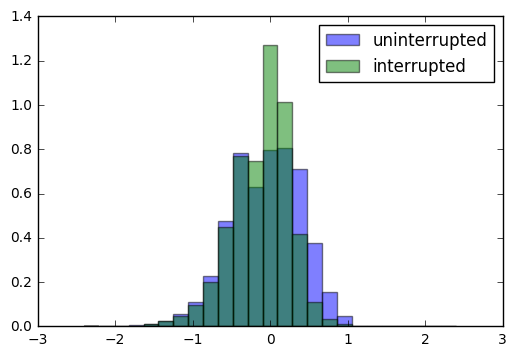

In [43]:
fig

In [193]:
stats_experiments.plot_mean_std_change(before_cross_unint, label='uninterrupted')
stats_experiments.plot_mean_std_change(before_cross_int, label='interrupted')

In [194]:
plt.legend()
plt.show()

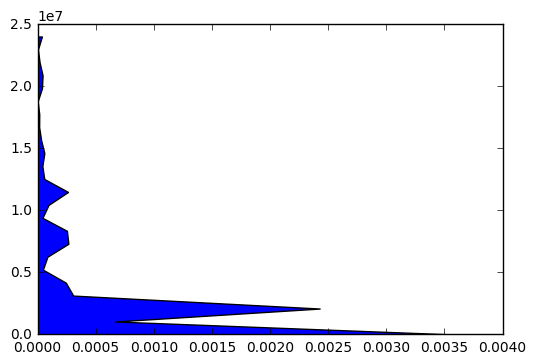

In [174]:
se.plot_jsd_devel(before_cross_unint)
plt.show()

In [172]:
%debug

> /home/erle/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py(4771)fill_betweenx()
   4769 
   4770         if not (y.shape == x1.shape == x2.shape == where.shape):
-> 4771             raise ValueError("Argument dimensions are incompatible")
   4772 
   4773         mask = reduce(ma.mask_or, [ma.getmask(a) for a in (y, x1, x2)])

ipdb> y
masked_array(data = [0.0 1044651.76 2089303.52 3133955.2800000003 4178607.04 5223258.8
 6267910.5600000005 7312562.32 8357214.08 9401865.84 10446517.6 11491169.36
 12535821.120000001 13580472.88 14625124.64 15669776.4 16714428.16
 17759079.92 18803731.68 19848383.44 20893035.2 21937686.96 22982338.72
 24026990.48 25071642.240000002],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False],
       fill_value = 1e+20)

ipdb> q


In [14]:
fig, ax = plt.subplots()
ax.set_xscale('log')
se.plot_jsd_comp_final(before_cross_unint, ax=ax)

In [9]:
ax.set_xlim([0.0, 0.03])

(0.0, 0.03)

In [15]:
ax.get_xlim()

(1.0000000000000001e-05, 0.10000000000000001)

In [16]:
plt.show()

Interesting: Interruptions don't move the whole thing to the left, but limit variance.

In [52]:
fig, ax = plt.subplots()
mesh = stats_experiments.plot_xss_cum_hist_change(xs, ax, bins=25)
#plt.colorbar(mesh)
plt.show()

In [7]:
del xs

In [54]:
p = '../data/Sarsa-disc-uninterrupted-xe-170221003432.pickle'
with open(p, 'rb') as f:
    res = pickle.load(f)
    
with open(p, 'wb') as f:
    pickle.dump(res[0:2], f)